# `1` Stock Prices

## `1.1` Linear Regression
Predicting stock prices using Linear Regression

In [68]:
import statsmodels.api as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsepython import *
from datetime import date
from scipy.stats import norm

run `fetch_data.py` to fetch data
<br />
if the data is already fetched, skip this step

In [70]:
index_data = pd.read_csv('./data/index_data.csv')
new_index_data = pd.read_csv('./data/new_index_data.csv')
data_old = pd.read_csv('./data/data_old.csv')

In [71]:
index_data

,HistoricalDate,Index Name,INDEX_NAME,OPEN,HIGH,LOW,CLOSE
0,2002-01-01,Nifty Bank,Nifty Bank,NaN,NaN,NaN,870.25
1,2002-01-02,Nifty Bank,Nifty Bank,NaN,NaN,NaN,878.02
2,2002-01-03,Nifty Bank,Nifty Bank,NaN,NaN,NaN,903.03
3,2002-01-04,Nifty Bank,Nifty Bank,NaN,NaN,NaN,903.90
4,2002-01-07,Nifty Bank,Nifty Bank,NaN,NaN,NaN,886.59
...,...,...,...,...,...,...,...
3546,2016-03-23,Nifty Bank,Nifty Bank,15884.25,15919.60,15799.95,15887.00
3547,2016-03-28,Nifty Bank,Nifty Bank,15867.75,15890.70,15522.20,15604.00
3548,2016-03-29,Nifty Bank,Nifty Bank,15583.10,15774.10,15580.80,15666.00
3549,2016-03-30,Nifty Bank,Nifty Bank,15829.60,16167.50,15762.20,16134.00


In [213]:
index_data['Returns'] = index_data['CLOSE'].pct_change()
index_data_returns = index_data.Returns[1:]

new_index_data['Returns'] = new_index_data['CLOSE'].pct_change()
new_index_data_returns = new_index_data.Returns[1:]

data_old['Returns'] = data_old['CH_CLOSING_PRICE'].pct_change()
asset_data_returns = data_old.Returns[1:]

In [226]:
asset_data_returns = asset_data_returns[-10:]
index_data_returns = index_data_returns[-10:]
asset_data_returns = np.array(asset_data_returns)
index_data_returns = np.array(index_data_returns)

In [227]:
asset_data_returns.shape

(10,)

In [228]:
index_data_returns.shape

(10,)

In [229]:
def ordinary_least_square_model(asset_returns, index_returns):
    asset_returns = stats.add_constant(asset_returns)
    model = stats.OLS(index_returns, asset_returns).fit()
    asset_returns = asset_returns[:, 1]
    return model

In [230]:
model = ordinary_least_square_model(asset_data_returns, index_data_returns)
model


In [231]:
alpha = model.params[0]
beta = model.params[1]

In [232]:
print("Alpha is: ", alpha)
print("Beta is: ", beta)

Alpha is:  0.0028320982595178884
Beta is:  0.6231877891948564


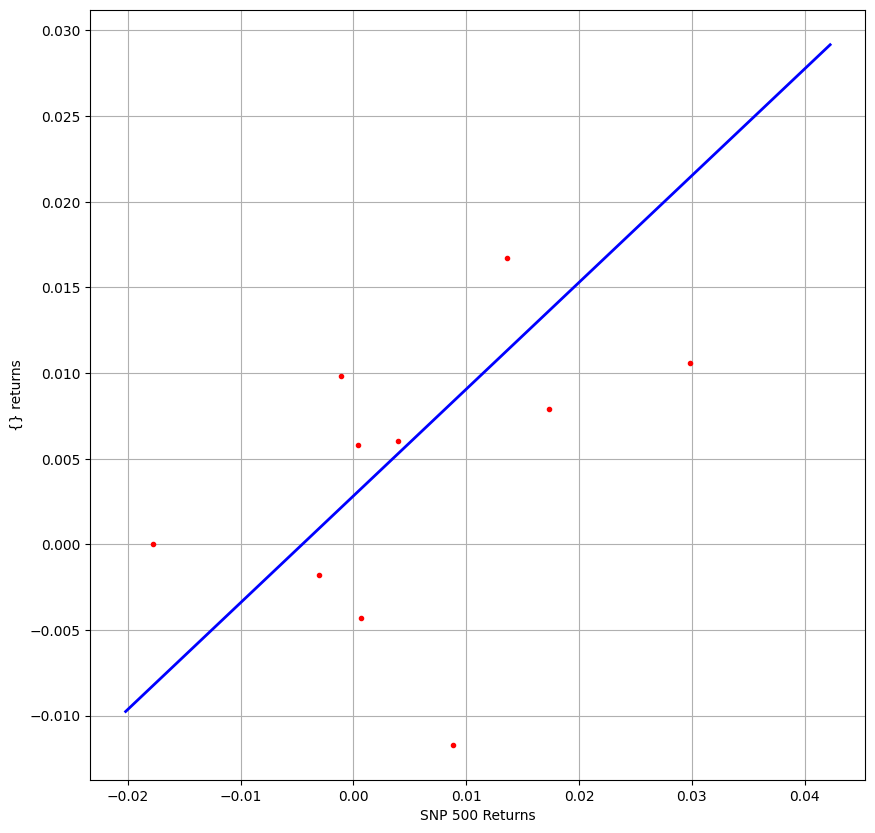

In [233]:
fig = plt.figure(figsize=(10, 10))
plt.plot(index_data_returns, asset_data_returns, 'r.')
ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, alpha + beta * x, 'b', lw=2)

plt.grid(True)
plt.axis('tight')
plt.xlabel('SNP 500 Returns')
plt.ylabel('{} returns')
plt.show()

In [234]:
# Calculating the asset returns
predicted_asset_returns = alpha + beta * new_index_data_returns

In [235]:
predicted_asset_returns = 1 + predicted_asset_returns
predicted_asset_returns

1      1.003449
2      0.983778
3      1.000489
4      0.998607
5      1.004357
         ...   
243    1.000885
244    1.007834
245    1.007706
246    1.009504
247    0.997759
Name: Returns, Length: 247, dtype: float64

In [236]:
predicted_asset_price = data_old['CH_CLOSING_PRICE'].iloc[-1] * predicted_asset_returns.cumprod()
predicted_asset_price[0:10]

1     1074.843948
2     1057.408354
3     1057.925888
4     1056.452585
5     1061.055509
6     1074.679048
7     1080.347696
8     1100.281231
9     1101.038435
10    1109.528495
Name: Returns, dtype: float64

In [237]:
# data_old['CH_CLOSING_PRICE'].iloc[-1]
model.rsquared

0.15944128387997902

`r-square` value shows that linear model does not fit well to past 10 days data.
<br>
Thus we move to the stochastic model derived using `Brownian Motion` using stochastic calculus. 

## `1.2` Stochastic Model

`2.2` Set `inflation rate` and `bond yield` to calculate `risk free rate` of return for our model
![./images/rfr.png](./images/rfr.png)

In [85]:
# Inflation rate is 3.85% as of 2023 April
inflation_rate = 0.0385

# 10 year bond yield is 7.229% as of 2023 April
bond_yield = 0.07229

# Risk free rate calculation
risk_free_rate = ((1 + bond_yield) /  (1 + inflation_rate)) - 1

print("Risk free rate is: ", risk_free_rate)

Risk free rate is:  0.032537313432835724


`2.3` As the required data is already fetced, read the csv files(`data_old` and `data_new`) from `data` folder and store the data in respective dataframes
<br />

In [86]:

data_old = pd.read_csv('./data/data_old.csv')
data_new = pd.read_csv('./data/data_new.csv')

`2.4` Add new colunm `log_returns` to the dataframe to store log returns
<br />
The log returns are calculated by taking the difference between the log of the `closing price of the current day` and the log of the `closing price of the previous day`.
<br />
`d_std` is the standard deviation of the daily returns
<br />
calculate `annualized_volatility` by multiplying the `daily standard deviation` by the square root of `252` (number of trading days in a year)
<br />
![./images/daily_returns.png](./images/volatility.png)
<br />
`spot_price` is the closing price of the stock on the last trading day of the year

In [87]:
data_old['log_returns'] = np.log(data_old['CH_CLOSING_PRICE'] / data_old['CH_CLOSING_PRICE'].shift(1))
# export to csv
data_old.to_csv(r'./data/data_old_log_returns.csv', index=False)

d_std = data_old['log_returns'].std()
annualized_volatility = d_std * 250 ** 0.5

# Spot price
spot_price = data_old['CH_CLOSING_PRICE'].iloc[-1]

In [88]:
# Using Numpy Arrays instead of Pandas DataFrames
# x = data_old["CH_CLOSING_PRICE"].values
# n = x.shape[0]
# window = int(10*252)
# # Calculating the log returns
# log_returns = np.log(x[n-window:n-1]/x[n-window-1:n-2])

# # Calculating the annualized volatility
# annualized_volatility = np.std(log_returns) * np.sqrt(252)
# spot_price = x[n-1]

# # Print the results
# print(annualized_volatility)
# print(spot_price)

`2.5` Calculate `mean price` of 30 days
<br />
considering the stock follows `brownian motion with drift`

In [89]:
m=10000
T=30.0/250.0
# for t in range(T):
def generate_prices(spot_price, risk_free_rate, annualized_volatility, T):
    expected_price = spot_price * np.exp((risk_free_rate - 0.5 * annualized_volatility ** 2) * T + annualized_volatility * np.sqrt(T) * np.random.normal(0, 1, m))
    return expected_price
mean_price = generate_prices(spot_price, risk_free_rate, annualized_volatility, T)
print(spot_price)
print(mean_price)

1071.15
[1214.43827218  818.5626674  1061.55226541 ... 1193.52807319 1076.09322124
 1163.4867477 ]


# `2` European Options
A European option is the type of options contract that allows investors to exercise their options only on the expiration date of that contract.

`2.6` Set the `strike price`: the price at which the option can be exercised
<br />
`payoff_generation` function calculates both `call` and `put` options' payoffs
![./images/payoff.png](./images/payoff.png)

In [90]:
strike_price = 1070.00
# Calculating Payoffs
def payoff_generation(strike_price, simulation_count = 10000):
    call_payoffs = []
    put_payoffs = []
    for i in range(simulation_count):
        mean_price = generate_prices(spot_price, risk_free_rate, annualized_volatility, T)
        call_payoff = np.maximum(mean_price - strike_price, 0)
        put_payoff = np.maximum(strike_price - mean_price, 0)
        call_payoffs.append(call_payoff)
        put_payoffs.append(put_payoff)
    return call_payoffs, put_payoffs

`2.7` Declare function to calculate `call` and `put` options' pricing using respective payoffs

In [91]:
# Calculating the call and put option prices
def option_price_calculation(strike_price, simulation_count = 10000):
    call_payoffs, put_payoffs = payoff_generation(strike_price, simulation_count)
    call_price = np.mean(call_payoffs) * np.exp(-risk_free_rate * T)
    put_price = np.mean(put_payoffs) * np.exp(-risk_free_rate * T)
    return call_payoffs, put_payoffs, call_price, put_price

`2.8` Call above declared function to calculate `call` and `put` pricing

In [92]:
# Executing the function
call_payoffs, put_payoffs, call_price, put_price = option_price_calculation(strike_price)

In [93]:
# Printing the results
print("Call Option price is: ", call_price)
print("Put Option price is: ", put_price)

Call Option price is:  80.30818671250358
Put Option price is:  74.98760677625498


In [94]:
# Calculating Put Call Parity
def put_call_parity_calculation(call_price, put_price, spot_price, strike_price, risk_free_rate, T):
    lhs = call_price - put_price
    rhs = spot_price - strike_price * np.exp(-risk_free_rate * T)
    return round(lhs) == round(rhs)

# Executing the function
put_call_parity_calculation(call_price, put_price, spot_price, strike_price, risk_free_rate, T)

True

In [95]:
# Now lets calculate the option price using Black Scholes formula
# First we need to calculate the d1 and d2 values

# Calculating d1
def d1_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d1 = (np.log(spot_price/strike_price) + (risk_free_rate + 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
    return d1

# Calculating d2
def d2_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d2 = (np.log(spot_price/strike_price) + (risk_free_rate - 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
    return d2

In [96]:
# Calculating the call and put option prices using Black Scholes formula
def option_price_calculation_black_scholes(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d1 = d1_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
    d2 = d2_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
    call_price = spot_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * T) * norm.cdf(d2)
    put_price = strike_price * np.exp(-risk_free_rate * T) * norm.cdf(-d2) - spot_price * norm.cdf(-d1)
    return call_price, put_price

In [97]:
# Executing the function
call_price_black_scholes, put_price_black_scholes = option_price_calculation_black_scholes(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
print("Call Option price using Black Scholes formula is: ", call_price_black_scholes)
print("Put Option price using Black Scholes formula is: ", put_price_black_scholes)

Call Option price using Black Scholes formula is:  80.30715965784196
Put Option price using Black Scholes formula is:  74.98751405418727
